In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
from scipy.signal import butter, filtfilt, freqz
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

# Load Data

In [3]:
filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/Volumes/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
f = h5py.File(filename, 'r')
electrode_info, session_info = loadmat(filename, variables=['electrodeInfo', 'sessionInfo'], verbose=False)
dt = get_sample_interval(f, units='s')
lfp = f['lfp']

# Neural Data (VAR)

In [49]:
# perform PCA on the entire data set
window = 5 # s
window_step = int(window/dt)
num_PCs = 3
pca = PCA(n_components=num_PCs)

lfp_pca = {}
explained_variance_pct = {}

for area in session_info['areas']:
# for area in ['vlPFC']:
    electrode_inds = np.where(electrode_info['area'] == area)[0]
    lfp_pca[area] = np.zeros((lfp.shape[1], num_PCs))
    
    num_win = int(np.floor(lfp.shape[1]/window_step))
    explained_variance_pct[area] = np.zeros(num_win)
    
    for i in tqdm(range(num_win)): 
        lfp_pca[area][i*window_step:(i + 1)*window_step] = pca.fit_transform(lfp[electrode_inds, i*window_step:(i + 1)*window_step].T)
        explained_variance_pct[area][i] = pca.explained_variance_ratio_.sum()

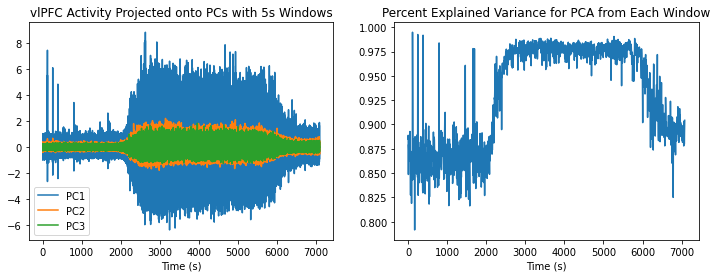

In [50]:
plt.figure(figsize=(12, 4))
area = 'vlPFC'

time_vals = np.arange(lfp_pca[area].shape[0])*dt
plt.subplot(1, 2, 1)
for i in range(lfp_pca[area].shape[1]):
    plt.plot(time_vals, lfp_pca[area][:, i], label=f'PC{i + 1}')
plt.legend()
plt.xlabel('Time (s)')
plt.title(f"{area} Activity Projected onto PCs with {window}s Windows")

plt.subplot(1, 2, 2)
plt.plot(np.arange(num_win)*window, explained_variance_pct[area])
plt.xlabel('Time (s)')
plt.title("Percent Explained Variance for PCA from Each Window")

plt.show()

In [51]:
# window is in time steps
# pts has shape (num_time_steps, num_dims)
def compute_eigs(pts, window):
    num_win = int(np.floor(pts.shape[0]/window))
    eigs = np.zeros((num_win, pts.shape[1]))
    for i in range(num_win):
        if i == 0:
            chunk = pts[:window]
        else:
            chunk = pts[i*window - 1:(i + 1)*window]
        model = VAR(chunk)
        results = model.fit(1)
        e,_ = np.linalg.eig(results.coefs[0])      
        eigs[i] = np.abs(np.real(e))
    
    return eigs

In [52]:
eigs = {}
for area in session_info['areas']:
# for area in ['vlPFC']:
    electrode_inds = np.where(electrode_info['area'] == area)[0]
    eigs[area] = compute_eigs(lfp_pca[area], window_step)

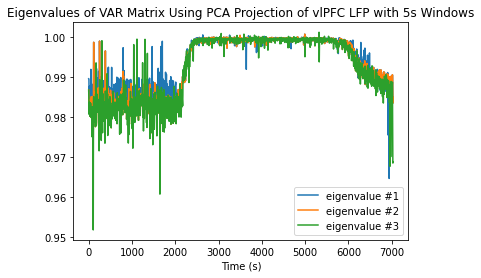

In [53]:
area = 'vlPFC'
for i in range(eigs[area].shape[1]):
    plt.plot((np.arange(num_win)*window)[:-10], eigs[area][:-10, i], label=f'eigenvalue #{i + 1}')
plt.legend()
plt.xlabel('Time (s)')
plt.title(f'Eigenvalues of VAR Matrix Using PCA Projection of {area} LFP with {window}s Windows')
plt.show()

In [57]:
eigs[area][:-10].mean(axis=1)

array([0.98772564, 0.98530168, 0.98314645, ..., 0.98534199, 0.97852053,
       0.97957538])

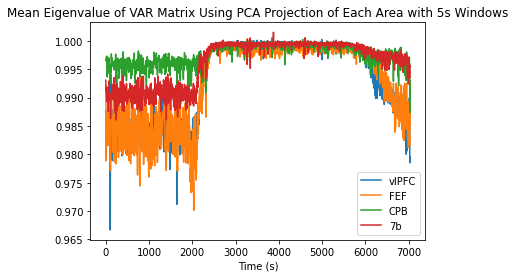

In [59]:
for area in session_info['areas']:
    plt.plot((np.arange(num_win)*window)[:-10], eigs[area][:-10].mean(axis=1), label=area)
plt.legend()
plt.xlabel('Time (s)')
plt.title(f'Mean Eigenvalue of VAR Matrix Using PCA Projection of Each Area with {window}s Windows')
plt.show()

# Neural Data (Reservoir)

In [49]:
# ======================
# SIGNAL PARAMETERS
# ======================

# unit_indices = [0, 10, 20]
unit_indices = np.where(lfp_areas == 'vlPFC')[0]
# trajectory_start_times = np.arange(0, 7001, 500) # s
start_time = 500 # s
duration = 10 # s


# ------------------
# get signal
# ------------------
start_step = int(start_time/dt)
length = int(duration/dt)
lfp_pts = f['lfp'][unit_indices, start_step:start_step + length].T
time_vals = np.arange(start_time, start_time+duration, dt)

# # normalize (gaussian normalization)
# for i in range(lfp_pts.shape[1]):
#     lfp_pts[:, i] = (lfp_pts[:, i] - np.mean(lfp_pts[:, i]))/np.std(lfp_pts[:, i])
# var_names = [f"unit_{unit_num} {lfp_areas[unit_num]}" for unit_num in unit_indices]
# time_vals = np.arange(start_time, start_time+duration, dt)

# for i in range(lfp_pts.shape[1]):
#     plt.plot(time_vals, lfp_pts[:, i], label=var_names[i])
# plt.xlabel('Time (s)')
# plt.title("Normalized LFP Data Streams")
# # plt.legend()

# plt.show()

In [43]:
# # FILTERING

# def butter_lowpass(cutoff, fs, order=5):
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     return b, a

# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     y = filtfilt(b, a, data)
#     return y

# # Filter requirements.
# order = 6
# fs = 1/dt      # sample rate, Hz
# cutoff = 50  # desired cutoff frequency of the filter, Hz

# # Get the filter coefficients so we can check its frequency response.
# b, a = butter_lowpass(cutoff, fs, order)

# plt.figure(figsize=(10, 5))

# # Plot the frequency response.
# w, h = freqz(b, a, worN=8000)
# plt.subplot(2, 2, 1)
# plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
# plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
# plt.axvline(cutoff, color='k')
# plt.xlim(0, 0.5*fs)
# plt.title("Lowpass Filter Frequency Response")
# plt.xlabel('Frequency [Hz]')
# plt.grid()

# # Demonstrate the use of the filter.
# length = 250
# data = lfp_pts[:length, 1]

# # Filter the data, and plot both the original and filtered signals.
# y = butter_lowpass_filter(data, cutoff, fs, order)

# plt.subplot(2, 2, 2)
# plt.plot(time_vals[:length], data, 'b-', label='data')
# plt.plot(time_vals[:length], y, 'g-', linewidth=2, label='filtered data')
# plt.xlabel('Time [sec]')
# plt.grid()
# plt.legend()
# plt.title(f"Sample Low-Pass Filtered LFP (cutoff = {cutoff} Hz, order = {order}) LFP Data Streams")

# plt.subplot(2, 1, 2)
# for i in range(lfp_pts.shape[1]):
#     lfp_pts[:, i] = butter_lowpass_filter(lfp_pts[:, i], cutoff, fs, order)
# for i in range(lfp_pts.shape[1]):
#     plt.plot(time_vals, lfp_pts[:, i], label=var_names[i])
# plt.xlabel('Time (s)')
# plt.title(f"Normalized and Low-Pass Filtered (cutoff = {cutoff} Hz, order = {order}) LFP Data Streams")

# # plt.subplots_adjust(hspace=0.35)
# plt.tight_layout()
# plt.show()

## PCA

In [58]:
pca = PCA(n_components=10)
pca_results = pca.fit(lfp_pts)
pca_results.explained_variance_ratio_

array([0.74694167, 0.07617356, 0.04584202, 0.02006163, 0.01691765,
       0.01026844, 0.00805772, 0.00636464, 0.00561068, 0.00437538])

In [59]:
lfp_pts_pca = pca.fit_transform(lfp_pts)

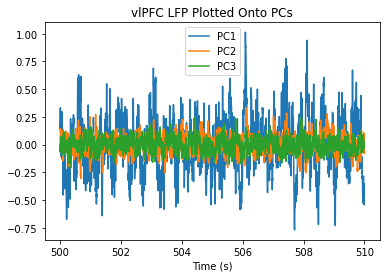

In [60]:
plt.plot(time_vals, lfp_pts_pca[:, 0], label='PC1')
plt.plot(time_vals, lfp_pts_pca[:, 1], label='PC2')
plt.plot(time_vals, lfp_pts_pca[:, 2], label='PC3')
plt.title('vlPFC LFP Plotted Onto PCs')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [68]:
pts = lfp_pts_pca[:, :2]
var_names = [f'PC{i + 1}' for i in range(pts.shape[1])]

In [57]:
# # PERFORM GAUSSIAN NORMALIZATION OF PCS
# for i in range(pts.shape[1]):
#     pts[:, i] = (pts[:, i] - np.mean(pts[:, i]))/np.std(pts[:, i])
# var_names = [f"unit_{unit_num} {lfp_areas[unit_num]}" for unit_num in unit_indices]

# plt.plot(time_vals, pts[:, 0], label='PC1')
# plt.plot(time_vals, pts[:, 1], label='PC2')
# plt.title('vlPFC LFP Plotted Onto PCs and Normalized')
# plt.xlabel('Time (s)')
# plt.legend()
# plt.show()

## Train Reservoir

In [78]:
# ======================
# RESERVOIR PARAMETERS
# ======================

D_r = 800 # number of reservoir nodes
d = int((6/299)*(D_r-1)) # average degree of Erdos-Renyi network
p = None # probability of an edge in the Erdos-Renyi network - if not None, overrides d
rho = 1.2 # spectral radius of the adjacency matrix

beta = 0
# beta = 1e-3 # regularization parameter
# sigma = 0.1 # maximum value of the input weights
sigma = 1/np.sqrt(300)

squared_inds = None

In [79]:
reservoir = ReservoirDS(pts, dt=dt, D_r=D_r, d=d, p=p, rho=rho, beta=beta, sigma=sigma, squared_inds=squared_inds, var_names=var_names)
reservoir.train_and_test(percent_training_data=0.5)

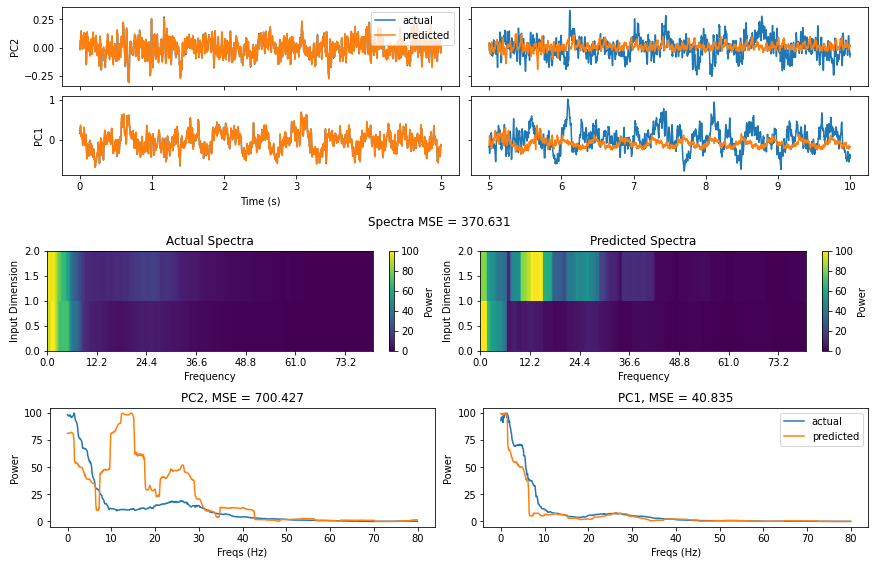

In [80]:
reservoir.plot_all()

In [53]:
reservoir.compute_lyap_spectrum_QR(debug=True)

Computing Jacobians



Computing Lyapunov spectrum


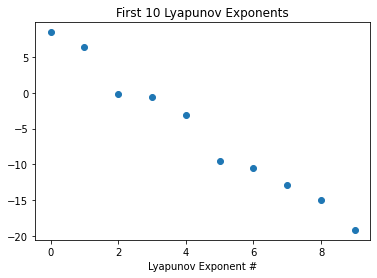

In [54]:
num = 10
plt.scatter(np.arange(num), reservoir.lyaps[:num])
plt.xlabel('Lyapunov Exponent #')
plt.title(f"First {num} Lyapunov Exponents")
plt.show()